In [14]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [17]:
# Define file paths
route_distances_path = Path("PeMSD7_Full") / "PeMSD7_W_228.csv"
speeds_array_path = Path("PeMSD7_Full") / "PeMSD7_V_228.csv"

# Load data
route_distances = pd.read_csv(route_distances_path, header=None).values
speeds_array = pd.read_csv(speeds_array_path, header=None).values

# Print shapes
print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

route_distances shape=(228, 228)
speeds_array shape=(12672, 228)


In [18]:
# Define sample routes
sample_routes = [
    0, 1, 4, 7, 8, 11, 15, 108, 109, 114, 115, 118, 120,
    123, 124, 126, 127, 129, 130, 132, 133, 136, 139, 144, 147, 216
]

# Select rows and columns from route_distances
route_distances = route_distances[np.ix_(sample_routes, sample_routes)]

# Select columns from speeds_array
speeds_array = speeds_array[:, sample_routes]

# Print shapes
print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

route_distances shape=(26, 26)
speeds_array shape=(12672, 26)


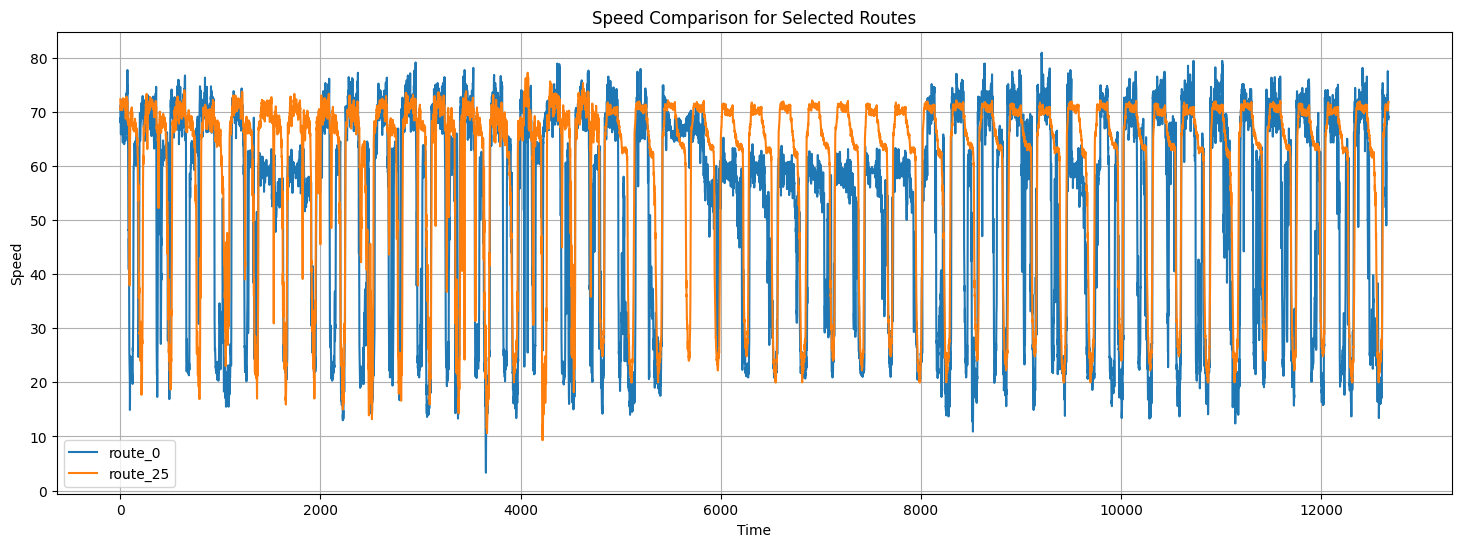

In [19]:
# Plot speeds for the first and last routes in sample_routes
plt.figure(figsize=(18, 6))
plt.plot(speeds_array[:, [0, -1]])
plt.legend(["route_0", "route_25"])

# Add title and labels
plt.title("Speed Comparison for Selected Routes")
plt.xlabel("Time")
plt.ylabel("Speed")
plt.grid(True)
plt.show()

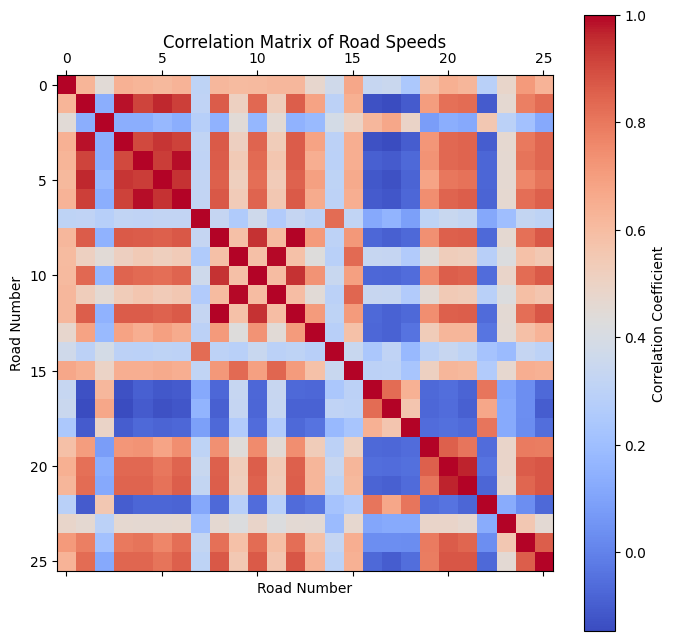

In [20]:
# Plot correlation matrix for the transposed speeds_array
plt.figure(figsize=(8, 8))
correlation_matrix = np.corrcoef(speeds_array.T)
plt.matshow(correlation_matrix, fignum=0, cmap="coolwarm")
plt.colorbar(label="Correlation Coefficient")

# Add title and adjust labels
plt.title("Correlation Matrix of Road Speeds", pad=20)
plt.xlabel("Road Number")
plt.ylabel("Road Number")

# Show plot
plt.show()

In [24]:
train_size, val_size = 0.5, 0.2

def preprocess(data_array: np.ndarray, train_size: float, val_size: float):

    num_time_steps = data_array.shape[0]
    num_train = int(num_time_steps * train_size)
    num_val = int(num_time_steps * val_size)

    # Calculate mean and std using only the training data
    mean = data_array[:num_train].mean(axis=0)
    std = data_array[:num_train].std(axis=0)

    # Normalize train, validation, and test sets
    train_array = (data_array[:num_train] - mean) / std
    val_array = (data_array[num_train : num_train + num_val] - mean) / std
    test_array = (data_array[num_train + num_val :] - mean) / std

    return train_array, val_array, test_array


train_array, val_array, test_array = preprocess(speeds_array, train_size, val_size)

print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")


train set size: (6336, 26)
validation set size: (2534, 26)
test set size: (3802, 26)


In [25]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

batch_size = 64 
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False


def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):
    # Expand data_array for input sequence preparation
    input_data = np.expand_dims(data_array[:-forecast_horizon], axis=-1)
    
    # Create input sequences
    inputs = timeseries_dataset_from_array(
        input_data,
        targets=None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    # Determine target start index and length
    target_offset = (
        input_sequence_length if multi_horizon else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1

    # Create target sequences
    targets = timeseries_dataset_from_array(
        data_array[target_offset:],
        targets=None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    # Zip inputs and targets into a single dataset
    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=100)

    return dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).cache()

# Create train and validation datasets
train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

# Create test dataset with the entire test_array in a single batch
test_dataset = create_tf_dataset(
    test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)


In [26]:
def compute_adjacency_matrix(route_distances: np.ndarray, sigma2: float, epsilon: float):
    num_routes = route_distances.shape[0]
    
    # Normalize the route distances
    normalized_distances = route_distances / 10000.0
    
    # Compute squared distances and the mask for adjacency
    squared_distances = normalized_distances ** 2
    mask = np.ones((num_routes, num_routes)) - np.eye(num_routes)
    
    # Compute the adjacency matrix based on the exponential decay
    adjacency_matrix = np.exp(-squared_distances / sigma2) >= epsilon
    
    # Apply the mask to eliminate self-connections
    return adjacency_matrix * mask

In [29]:
import typing
import numpy as np

class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes

# Parameters for adjacency matrix computation
sigma2 = 0.1
epsilon = 0.5

# Compute the adjacency matrix
adjacency_matrix = compute_adjacency_matrix(route_distances, sigma2, epsilon)

# Extract node and neighbor indices
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)

# Create the graph information object
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)

# Print the number of nodes and edges
print(f"Number of nodes: {graph.num_nodes}, Number of edges: {len(graph.edges[0])}")


Number of nodes: 26, Number of edges: 150


In [30]:
class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat: int,
        out_feat: int,
        graph_info: GraphInfo,
        aggregation_type: str = "mean",
        combination_type: str = "concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        
        # Weight initialization
        self.weight = tf.Variable(
            initial_value=keras.initializers.GlorotUniform()(
                shape=(in_feat, out_feat), dtype="float32"
            ),
            trainable=True,
        )
        
        self.activation = layers.Activation(activation) if activation else None

    def aggregate(self, neighbour_representations: tf.Tensor) -> tf.Tensor:
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor) -> tf.Tensor:
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor) -> tf.Tensor:
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor) -> tf.Tensor:
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h) if self.activation else h

    def call(self, features: tf.Tensor) -> tf.Tensor:
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)

In [31]:
class LSTMGC(layers.Layer):
    def __init__(
        self,
        in_feat: int,
        out_feat: int,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # Initialize graph convolution layer with default parameters if none are provided
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)
        self.lstm = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len)

        self.input_seq_len = input_seq_len
        self.output_seq_len = output_seq_len

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        # Transpose inputs to match the expected shape
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        # Apply graph convolution
        gcn_out = self.graph_conv(inputs) 

        # Get the shape of the graph convolution output
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = shape[0], shape[1], shape[2], shape[3]

        # Reshape output for LSTM
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        lstm_out = self.lstm(gcn_out)  

        # Apply dense layer and reshape output for final return
        dense_output = self.dense(lstm_out) 
        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        
        # Transpose output to the required shape
        return tf.transpose(output, [1, 2, 0])

In [32]:
# Hyperparameters
in_feat = 1
batch_size = 64
epochs = 20
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False
out_feat = 10
lstm_units = 64

# Graph convolution parameters
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

# Initialize the LSTMGC model
st_gcn = LSTMGC(
    in_feat=in_feat,
    out_feat=out_feat,
    lstm_units=lstm_units,
    input_seq_len=input_sequence_length,
    output_seq_len=forecast_horizon,
    graph_info=graph,
    graph_conv_params=graph_conv_params,
)

# Define input layer
inputs = layers.Input(shape=(input_sequence_length, graph.num_nodes, in_feat))

# Get model outputs
outputs = st_gcn(inputs)

# Create and compile the model
model = keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=keras.losses.MeanSquaredError(),
)

# Train the model
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.6300 - val_loss: 0.2976
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.2719 - val_loss: 0.1579
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.1516 - val_loss: 0.1141
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.1211 - val_loss: 0.0994
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.1076 - val_loss: 0.0905
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.0988 - val_loss: 0.0837
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0921 - val_loss: 0.0786
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0870 - val_loss: 0.0757
Epoch 9/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0841 - val_loss: 0.0744
Epoch 10/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0825 - val_loss: 0.0738
Epoch 11/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0815 - val_loss: 0.0734
Epoch 12/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


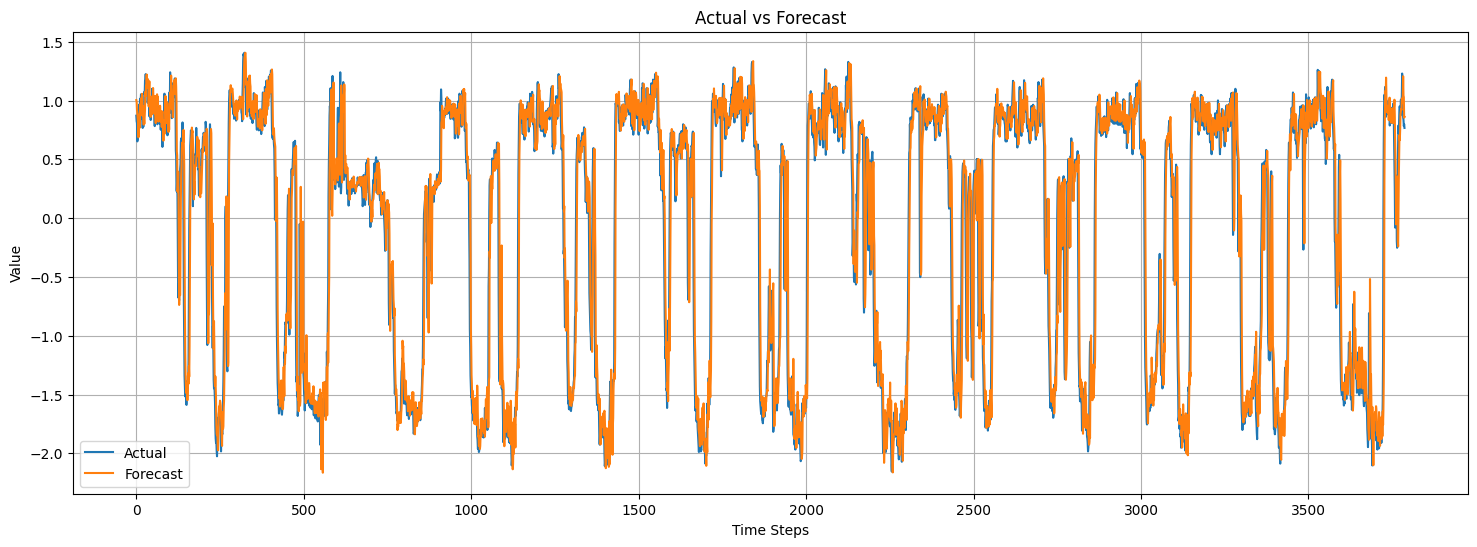

Naive MAE: 0.1347, Model MAE: 0.1274


In [33]:
# Get test data
x_test, y = next(test_dataset.as_numpy_iterator())

# Make predictions
y_pred = model.predict(x_test)

# Plot the actual vs predicted values
plt.figure(figsize=(18, 6))
plt.plot(y[:, 0, 0], label="Actual")
plt.plot(y_pred[:, 0, 0], label="Forecast")
plt.legend()
plt.title("Actual vs Forecast")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.grid()
plt.show()

# Calculate Mean Squared Error (MSE) for naive and model predictions
naive_mse = np.square(x_test[:, -1, :, 0] - y[:, 0, :]).mean()
model_mse = np.square(y_pred[:, 0, :] - y[:, 0, :]).mean()

# Print results
print(f"Naive MAE: {naive_mse:.4f}, Model MAE: {model_mse:.4f}")